In [57]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import EstimatorPreprocessor as ep
from datetime import datetime
import math
from numpy import concatenate

In [2]:
# Obtain sentiment

In [3]:
data = ep.load_cleaned_submissions()

In [4]:
df = pd.DataFrame()

In [5]:
df["Date"] = pd.to_datetime(data.created_utc.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')))
df["Sentiment"] = data.sentiment
df["Scores"] = df.Sentiment.apply(lambda x: 1 if x == "bullish" else (-1 if x == "bearish" else 0))

In [6]:
df = df.groupby("Date", as_index = False)["Scores"].sum("Sum")

In [7]:
df["LogScores"] = df.Scores.apply(lambda x: math.log(x) if x > 0 else 0)

In [8]:
# Start Time Series Analysis

In [9]:
ts = pd.read_excel("data/stock_prices.xlsx", usecols = ["Date", "Adj Close", "Volume"])
ts["Close_Diff"] = ts["Adj Close"].diff()

In [10]:
# Add sentiment to stock price time series data
ts = pd.merge(ts, df, how = "left", on = "Date").fillna(0)
ts

,Date,Adj Close,Volume,Close_Diff,Scores,LogScores
0,2019-12-31,6.080000,4322600,0.000000,0.0,0.000000
1,2020-01-02,6.310000,4453600,0.230000,0.0,0.000000
2,2020-01-03,5.880000,3543900,-0.430000,0.0,0.000000
3,2020-01-06,5.850000,3394800,-0.030000,1.0,0.000000
4,2020-01-07,5.520000,5228000,-0.330000,0.0,0.000000
...,...,...,...,...,...,...
454,2021-10-19,186.789993,2070600,0.769989,28.0,3.332205
455,2021-10-20,184.520004,2276900,-2.269989,9.0,2.197225
456,2021-10-21,181.710007,2402400,-2.809998,19.0,2.944439
457,2021-10-22,169.800003,2800400,-11.910004,25.0,3.218876


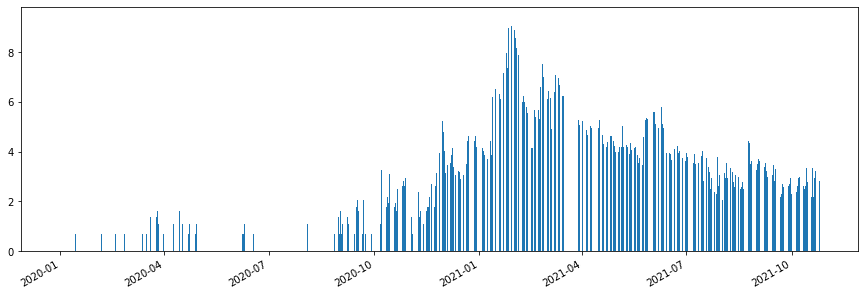

In [11]:
# Add stock prices and volume a bit later
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(ts.Date, ts.LogScores)
ax.tick_params(axis="x", labelbottom=True, rotation=45)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.show()

In [12]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ts.loc[:, ["Adj Close", "Scores", "LogScores", "Volume"]])

In [13]:
# Train, test split
series = training_set_scaled
train_size = int(round(len(series) * 0.90, 0))

train_set = series[:train_size]
test_set = series[train_size:]

In [14]:
assert (len(train_set) + len(test_set)) == len(series)

In [15]:
def create_dataset(dataset, look_back = 1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

In [18]:
LOOK_BACK = 2
X_train, y_train = create_dataset(train_set, LOOK_BACK)
X_test, y_test = create_dataset(test_set, LOOK_BACK)

In [36]:
# The LSTM network expects the input data (X) to be provided in the form of: [samples, time steps, features].
# Currently, our data is in the form: [samples, time steps]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [37]:
X_train.shape

(410, 2, 4)

In [38]:
def build_model(opt):
    model = Sequential()
    model.add(LSTM(4, input_shape = (LOOK_BACK, X_train.shape[2]))) # , return_sequences = True
    # model.add(LSTM(4, input_shape = (1, LOOK_BACK))) # If more layers are included, the comment from above also needs to be included.
    model.add(Dense(1))
    model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = 'RootMeanSquaredError')
    return model

In [39]:
param_list = []

opti = ['adam']

for opt in opti:
    model = build_model(opt)
    history = model.fit(X_train, y_train, epochs = 20, batch_size = 1, validation_split = 0.2, verbose = 0)
    param_list.append("Dropout: " + str(0) + 
                            " & Optimizer:" + opt +
                            " ;Train MSE: " + str(history.history['root_mean_squared_error']) + 
                            " ;Train Loss: "+ str(history.history['loss']) + 
                            " ;Val MSE:" + str(history.history['val_root_mean_squared_error']) +
                            " ;Val Loss:" + str(history.history['val_loss'])
                            )

2021-12-26 17:38:14.112756: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


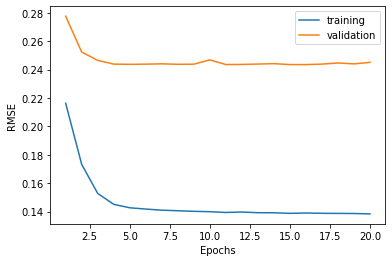

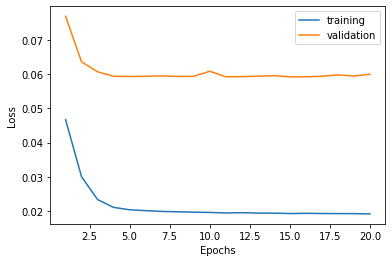

In [69]:
import matplotlib.pyplot as plt

rmse_history = history.history["root_mean_squared_error"]
val_rmse_history = history.history["val_root_mean_squared_error"]

plt.plot(range(1, len(rmse_history) + 1), rmse_history)
plt.plot(range(1, len(val_rmse_history) + 1), val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

In [78]:
def inverse_prediction(data):
    test_X = data.reshape((data.shape[0], 8))
    yhat = model.predict(data)
    testPredict = concatenate((yhat, test_X[:, -3:]), axis=1)
    testPredict = sc.inverse_transform(testPredict)
    return testPredict[:, 0]

In [71]:
y_test = sc.inverse_transform(y_test)[:, 0]

In [79]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = inverse_prediction(X_train)
testPredict  = inverse_prediction(X_test)
testScore = math.sqrt(mean_squared_error(y_test, testPredict))

In [80]:
testScore

122.0987592648885

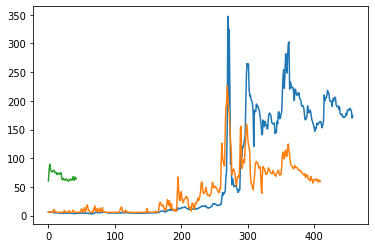

In [104]:
trainPredictPlot = np.empty_like(training_set_scaled)
trainPredictPlot[:, :] = np.nan

testPredictPlot = np.empty_like(training_set_scaled)
testPredictPlot[:, :] = np.nan

plt.plot(sc.inverse_transform(training_set_scaled)[:, 0])
plt.plot(trainPredict)
plt.plot(testPredict)
plt.show()

In [110]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(trainPredict)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LOOK_BACK:len(trainPredict)+LOOK_BACK, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(testPredict)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LOOK_BACK*2)+1:len(training_set_scaled)-1, :] = testPredict
# plot baseline and predictions
plt.plot(sc.inverse_transform(training_set_scaled)[:, 0])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed